# Proyecto 2: De clasificación a NER

Andrés Felipe Gámez, Camilo Andrés Gómez y Manuela Acosta Fajardo

En este proyecto utilizarán [este dataset](https://archive.ics.uci.edu/ml/datasets/Paper+Reviews) que consiste en evaluaciones de diferentes revisores sobre papers (405). Cada evaluación ha sido etiquetada con 5 clases (muy negativo, negativo, 0, neutral, positivo y muy positivo). Este proyecto consiste en realizar una clasificación de este dataset y además identificar que parte de los comentarios hacen referencia a las clases. 

## Parte 1. Clasificación sencilla de cada revisión

En esta parte tendrá que hacer un modelo de clasificación usando redes recurrentes (LSTM, GRU), para los cinco tipos de categorias.  Recuerde algunos pasos para realizar la clasificación:

1. Lectura de los datos (división en training/validation sets)
2. Preprocesamiento del texto (no es necesario ser tanto preprocesamiento como en word2vec, pero si eliminar algunos carácteres o incluso revisar si hay comentarios vacíos). 
3. Creación del vocabulario y transformación de palabras a índices (y viceversa)
4. Creación del "dataset" y "dataloader" involucrando los pasos 2 y 3.
5. Creación del modelo, involucrando embeddings.
6. Entrenar y validar (escoger optimizador Adam o AdamW, función de costo apropiada, loops de entrenamiento y validación).
7. Modelo listo para producción (modelo para predecir entrando un comentario)
8. Pequeña interfaz para predicción usando Gradio.

Realice diferentes configuraciones, tamaño del embedding, arquitecturas LSTM o GRU, varias capas, bidireccionalidad, etc. Escoja el mejor modelo. 

-----
Es importante que realicen gráficos y visualizaciones que ayuden a la interpretación. No olviden ir analizando y comentando los hallazgos, y sobretodo **concluir**. El entregable es un notebook de Jupyter, debidamente presentado y comentado.

- ¿Qué diferencian encuentran con un tipo de clasificación respecto al otro?
- ¿Los pesos de una tarea ayudan a la otra?
- ¿Es posible analizar o intuir a partir de pesos o activaciones, que parte del texto está ayudando en la parte 1 a clasificar?

In [1]:
import json
import torch
import pandas as pd
import torch.nn as nn
import gradio as gr
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from collections import Counter, OrderedDict
from torchtext.vocab import vocab
from unicodedata import normalize
import numpy as np
import re

import matplotlib.pyplot as plt

Cargamos los datos del archivo para obtener el dataframe y eliminamos aquellas revisiones que no tienen comentarios.

In [2]:
# load data using Python JSON module
with open('reviews.json','r') as f:
    data = json.loads(f.read())

df = pd.json_normalize(data['paper'], record_path = ["review"])

#quitando comentarios vacios
DF=df['text'][df['text']=='']
data=df.drop(DF.index.tolist(),axis=0)

Definimos las funciones de preprocesamiento del texto, para quitar tildes,pasar a minúsculas, eliminar algunos caracteres especiales como números y guiones.

In [3]:
def quitartildes(s):
    s = re.sub(
            r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
            normalize( "NFD", s), 0, re.I
        )
    
    return normalize( 'NFC', s)

def preprocess_sentence(sentence):

  l=(re.sub(r'[(0-9)]','',quitartildes(sentence)).lower().split())
  k=[i for i in l if i!='-']
  return ' '.join(k)

In [4]:
data['text_clean']=data['text'].apply(preprocess_sentence)

In [5]:
data

,confidence,evaluation,id,lan,orientation,remarks,text,timespan,text_clean
0,4,1,1,es,0,,- El artículo aborda un problema contingente y...,2010-07-05,el articulo aborda un problema contingente y m...
1,4,1,2,es,1,,El artículo presenta recomendaciones prácticas...,2010-07-05,el articulo presenta recomendaciones practicas...
2,5,1,3,es,1,,- El tema es muy interesante y puede ser de mu...,2010-07-05,el tema es muy interesante y puede ser de much...
3,4,2,1,es,1,,Se explica en forma ordenada y didáctica una e...,2010-07-05,se explica en forma ordenada y didactica una e...
5,4,2,3,es,0,,Los autores describen una metodología para des...,2010-07-05,los autores describen una metodologia para des...
...,...,...,...,...,...,...,...,...,...
400,5,-1,1,es,-2,,El trabajo pretende ofrecer una visión del uso...,2015-07-05,el trabajo pretende ofrecer una vision del uso...
401,4,-1,2,es,-1,,El paper está bien escrito y de fácil lectura....,2015-07-05,el paper esta bien escrito y de facil lectura....
402,4,-1,1,es,0,,Observación de fondo: No se presenta un ejemp...,2015-07-05,observacion de fondo: no se presenta un ejempl...
403,3,1,2,es,-1,,Se propone un procedimiento para elaborar máqu...,2015-07-05,se propone un procedimiento para elaborar maqu...


Tomamos de los notebooks del curso, la clase `TextData` para facilitar el manejo de los datos y la división en training y validación. Por lo que, dividimos los datos en 70% entrenamiento y 30% validación.

In [6]:
class TextData(Dataset):
    '''
    Dataset basico para leer los datos de tweets
    '''
    def __init__(self, dataFrame):
        super(TextData, self).__init__()
        #df = pd.read_csv(filename,encoding='latin-1')
        self.df = dataFrame[["evaluation", "text_clean"]]
        
    def __getitem__(self, index):
        return self.df.iloc[index,0], self.df.iloc[index,1]
    
    def __len__(self):
        return len(self.df)

In [7]:
TextD= TextData(data)
train_dataset, valid_dataset = random_split(TextD,[int(len(TextD)*0.7),len(TextD) - int(len(TextD)*0.7)], torch.manual_seed(42))

Ahora, procesando los datos de entrenamiento creamos el vocabulario e introducimos los tokens para palabras desconocidas y de relleno en caso de que se necesitan a la hora de procesar la información para ingresarla a la red.

In [8]:
tok_c = Counter()
for label, line in train_dataset:
    tokens = line.split()
    tok_c.update(tokens)


sorted_by_freq_tuples = sorted(tok_c.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

Definimos la función `collate_batch` que procesa el texto para ponerlo en el formato que puede recibir la red. Para ellos usamos dos funciones auxiliares: `text_pipeline` que pasa de palabras a índices y `label_pipeline` que reordena los labels del dataset para que coincidan con las posiciones del arreglo de salida de la red, por ejemplo, la clase *muy negativo* tiene label **-2** pero la función `label_pipeline` la reasigna al label 0 para hacer más fácil el calculo del accuracy y del loss.

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

text_pipeline = lambda x: [vocab[token] for token in x.split()]
label_pipeline = lambda x: 0 if int(x)==-2 else (1 if int(x)==-1 else (2 if int(x)==0 else (3 if int(x)==1 else 4 )))

def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text),dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence( text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

#### El modelo

Se construyo una red neuronal recurrente con:

- 2 capas LSTM bidireccionales
- 1 capa lineal 
- 1 capa de dropout con probabilidad 0.4
- 1 capa lineal de salida (con dimensión 5 para cada clase)



In [10]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size,num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.dropout=nn.Dropout(p=0.4)
        self.out_l = nn.Linear(fc_hidden_size, 5)

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, (hidden, cell) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.out_l(out)
        return out

Definimos las funciones para entrenar el modelo y evaluarlo con el conjunto de validación. Tomamos las funciones de los notebooks del curso, haciendo pequeñas modificaciones para adaptarlas a nuestro ejercicio.

In [11]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        pred = model(text_batch, lengths)
        loss = loss_fn(pred, label_batch.long())

        loss.backward()
        optimizer.step()
        total_acc += (pred.argmax(axis=1).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)
 
def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            pred = model(text_batch, lengths)
            loss = loss_fn(pred, label_batch.long())
            total_acc += (pred.argmax(axis=1).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

Inicializamos el modelo usando una dimesión de embedding de 100, 100 neuronas en las capas ocultas de LSTM y 60 neuronas en la capa intermedia lineal. Usamos el optimizador **AdamW** y un learning rate de 0.001. Además empleamos la entropía cruzada como función de costo para entrenar el modelo.

In [12]:
vocab_size = len(vocab)
embed_dim = 100
rnn_hidden_size = 100
fc_hidden_size = 60

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

¡Entrenando el modelo! 

Usamos 10 epocas porque el modelo es pesado y observamos que entrenar durante más epocas no conducía a mejores resultados.

In [13]:
#generando los batchs
batch_size = 30  

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# entrenando...
num_epochs = 10
torch.manual_seed(1)
train_losses=[]
valid_losses=[]
train_accs=[]
valid_accs=[]
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    train_losses.append(loss_train)
    train_accs.append(acc_train)
    valid_losses.append(loss_valid)
    valid_accs.append(acc_valid)
    print(f'Epoch {epoch} => loss: {loss_train:.4f} val_loss:{loss_valid:.4f} | accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')

Epoch 0 => loss: 1.6056 val_loss:1.5931 | accuracy: 0.2007 val_accuracy: 0.2750
Epoch 1 => loss: 1.5713 val_loss:1.5835 | accuracy: 0.3333 val_accuracy: 0.2667
Epoch 2 => loss: 1.5221 val_loss:1.5685 | accuracy: 0.3943 val_accuracy: 0.2750
Epoch 3 => loss: 1.4092 val_loss:1.5971 | accuracy: 0.4158 val_accuracy: 0.2750
Epoch 4 => loss: 1.2669 val_loss:1.6538 | accuracy: 0.5161 val_accuracy: 0.2667
Epoch 5 => loss: 0.9993 val_loss:1.7066 | accuracy: 0.6487 val_accuracy: 0.3333
Epoch 6 => loss: 0.7328 val_loss:1.9064 | accuracy: 0.7384 val_accuracy: 0.3250
Epoch 7 => loss: 0.4827 val_loss:2.0956 | accuracy: 0.8315 val_accuracy: 0.2500
Epoch 8 => loss: 0.3063 val_loss:2.9646 | accuracy: 0.9211 val_accuracy: 0.2583
Epoch 9 => loss: 0.1466 val_loss:2.9666 | accuracy: 0.9498 val_accuracy: 0.2667


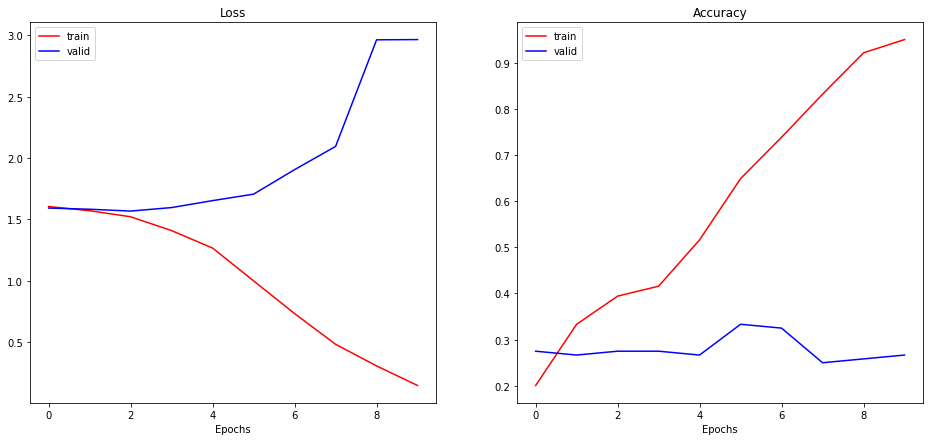

In [14]:
fig, ax = plt.subplots(1,2,figsize=(16,7))
ax[0].plot(range(num_epochs), train_losses, 'r', label='train')
ax[0].plot(range(num_epochs), valid_losses, 'b', label = 'valid')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(range(num_epochs), train_accs, 'r', label='train')
ax[1].plot(range(num_epochs), valid_accs, 'b', label = 'valid')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
plt.show()

De las gráficas de loss y accuracy para los dos conjuntos de datos, encontramos una tendencia al *overfitting*. Al variar tanto los parámetros de la arquitectura de la red como el tiempo de entrenamiento, observamos que el comportamiento no mejora, por lo que concluimos que el problema sean probablemente los datos (comentarios) que: 

- No han sido completamente procesados
- No brindan información suficiente para que la red aprenda el patrón para asignar correctamente las clases.


### Alistando para producción

Se definen las funciones `collate_prod` que procesa el texto para ingresarlo al modelo y la función `evalu` que recibe el texto, lo ingresa al modelo y traduce la salida en las etiquetas originales del dataset.

In [15]:
def collate_prod(batch):
    init_tex=preprocess_sentence(batch)
    text_list, lengths = [], []
    processed_text = torch.tensor(text_pipeline(init_tex),dtype=torch.int64)
    lengths.append(processed_text.size(0))
    lengths = torch.tensor(lengths)
    return processed_text.to(device), lengths.to(device)

def evalu(Comentario):
  L=['Muy negativo','Negativo','Neutral','Positivo','Muy positivo']
  pro_comment,lengt=collate_prod(Comentario)
  rep=pro_comment.view(1,pro_comment.shape[0])
  pred = model(rep, lengt)
  label=pred.argmax(axis=1).float().item()
  return [(L[int(label)],str(int(label)))]

#### GUI

In [16]:
# Interfaz gráfica
iface = gr.Interface(
    fn = evalu,
    inputs= ["text"],
    outputs=gr.outputs.HighlightedText(color_map={"0": "red", "1": "orange","2":"gray","3":"blue","4":"green"},label='Calificación',show_legend=False),
    allow_flagging="never",
    title = 'Evaluador de comentarios',
    description = 'Ingrese un comentario/review y se le indicará la evaluación del comentario',
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://18723.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f437fa5be50>,
 'http://127.0.0.1:7860/',
 'https://18723.gradio.app')

#### Análisis

En este caso, a partir de los pesos directamente no es posible encontrar qué partes de los comentarios aportan más a determinar el label del comentario, porque al hacer el *embedding*, ya no existe una correspondencia entre las palabras y los pesos de la red en sus diferentes capas. Sin embargo, pudimos encontrar algunos patrones relacionados con ciertas palabras en los comentarios y el label asociado. Por ejemplo, la palabra **muy** se relaciona con el label *muy positivo*, dado que siempre que se incluye en un comentario, el modelo le asigna esa clase. Esto se debe, probablemente, a que muchos comentarios del conjunto de entrenamiento que tenian la palabra **muy** estaban clasificados como *muy positivos*. Igualmente, la palabra **no** se asocia con la clase *negativo*, de hecho, algunos comentarios que son positivos si incluyen la palabra **no** serán clasificados como negativos. Por lo que podemos concluir que, en efecto hay palabras que son más importantes al momento de calcular la clase y consideramos que esas palabras importantes se asocian con la frecuencia con la que aparecen al momento de entrenar el modelo.

# Parte 2: Problema de clasificación por palabras o frases (NER)

Luego de realizar el debido etiquetado de cada una de las frases pertenecientes a los comentarios del índice 200 al 250, procedemos a crear el dataframe con dichos comentarios y sus etiquetas por frases. Para ello, creamos dos columnas, `data`, donde se encuentra el texto de cada uno de los comentarios, y `label`, donde se encuentran listas con los labels correspondientes a las frases de ese comentario, y las posiciones exactas de estos labels. 

In [17]:
df2 = pd.DataFrame(columns = ['text', 'label'])
with open('admin.jsonl','r', encoding='cp1252') as f:
    str_contents = f.read()
    contents_aux = str_contents.split('\n')
    contents = [str(i) for i in contents_aux]
    i=0
    for line in contents:
      try:
        data = json.loads(line)
        df2.loc[i] = [(data["data"]), list(data["label"])]
        i += 1
      except:
        pass

In [18]:
df2.head()

,text,label
0,me parece un articulo interesante que pudo cen...,"[[0, 33, Positivo], [940, 1053, Neutro]]"
1,. el articulo esta muy mal escrito. por ejempl...,"[[2, 34, Muy negativo], [245, 293, Negativo], ..."
2,"en mi opinion, siendo la propuesta de muy alto...","[[54, 108, Negativo], [111, 166, Positivo], [3..."
3,el articulo describe los conceptos de data war...,"[[239, 263, Negativo], [265, 348, Muy negativo]]"
4,si bien este articulo deja ver una buena canti...,"[[8, 60, Positivo], [62, 128, Negativo], [129,..."


Ahora, creamos una función que, de acuerdo con la lista de labels obtenida de codificar manualmente las frases de cada comentario, nos permite etiquetar cada palabra. En caso de que haya palabras que no estén etiquetadas, pertenecen a la clase `otros`. Además, definimos cada categoría numéricamente, es decir: 
- Otros = 0
- Muy negativo = 1
- Negativo = 2
- Neutro = 3
- Positivo = 4
- Muy positivo = 5

Definimos, a su vez, una función para quitar la puntuación de los comentarios, para evitar problemas futuros con la codificación de las palabras.

In [19]:
import copy

def quitar(list_text):
  new_text = list_text.copy()
  dic = ['a', 'o', 'y', 'u', 'e']
  for palabra in list_text:
    if len(palabra) == 1 and palabra not in dic:
      new_text.remove(palabra)
  return new_text

In [20]:
def codificar(texto, labels):
  dic_labels = {"Otros": 0,
                "Muy negativo": 1,
                "Negativo": 2,
                "Neutro": 3,
                "Positivo":4,
                "Muy postivo": 5}
  palabras = texto.split()
  cod = []
  idxs0 = []
  idxs1 = []
  labels_ = []
  for label in labels:
    idx0, idx1, lab = label
    idxs0.append(idx0)
    idxs1.append(idx1)
    labels_.append(lab)
  for i in range(len(idxs0)):
    last = 0 
    if i == 0 and idxs0[i] != 0:
      cant_palabras3 = len(texto[0: idxs0[i]-1].split())
      cod += [dic_labels["Otros"]]*cant_palabras3
      last = idxs0[i]-1

    cant_palabras = len(texto[idxs0[i]: idxs1[i]].split())
    cod += [dic_labels[labels_[i]]]*cant_palabras
    last = idxs1[i]
    if i < len(idxs0)-1:
      cant_palabras2 = len(texto[idxs1[i]+1: idxs0[i+1]].split())
      cod += [dic_labels["Otros"]]*cant_palabras2
      last = idxs0[i+1]

    elif i == len(idxs1)-1 and idxs1[i] != len(texto):
      cant_palabras4 = len(texto[idxs1[i]+1:].split())
      cod += [dic_labels["Otros"]]*cant_palabras4
      last = len(texto)

  return cod

Definimos, nuevamente, una clase `TextData2`, que nos permite la división de los datos en datos de entrenamiento y validación. Para ello, una vez más, tomamos el 70% y el 30%, respectivamente. 

In [21]:
class TextData2(Dataset):
    '''
    Dataset basico para leer los datos de tweets
    '''
    def __init__(self, dataFrame):
        super(TextData2, self).__init__()
        #df = pd.read_csv(filename,encoding='latin-1')
        self.df = dataFrame[["label", "text"]]
        
    def __getitem__(self, index):
        return self.df.iloc[index,0], self.df.iloc[index,1]
    
    def __len__(self):
        return len(self.df)

In [22]:
corpus = df2.iloc[:,0]

In [23]:
TextD2 = TextData2(df2)
train_dataset, valid_dataset = random_split(TextD2, [int(len(TextD2)*0.7), len(TextD2) - int(len(TextD2)*0.7)], torch.manual_seed(42))

Creamos el vocabulario al procesar los datos de entrenamiento, y nuevamente introducimos los tokens correspondientes a palabras desconocidas y de relleno.

In [24]:
from torchtext.vocab import vocab

tok_c = Counter()
for label, line in train_dataset:
    tokens = line.split()
    tok_c.update(tokens)


sorted_by_freq_tuples = sorted(tok_c.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

Nuevamente definimos funciones que usaremos en el modelo. 

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

text_pipeline = lambda x: [vocab[token] for token in x.split()]
label_pipeline = lambda x, y: [codificar(x,y)]

def collate_batch2(batch):
    label_list, text_list, lengths = [], [], []
    for _labels, _text in batch:
        processed_label=torch.tensor(codificar(_text, _labels))      
        label_list.append(processed_label)
        processed_text = torch.tensor(text_pipeline(_text), 
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    label_list = nn.utils.rnn.pad_sequence(
        label_list, batch_first=True, padding_value=0)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [26]:
from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=15, shuffle=True, collate_fn=collate_batch2)
text_batch, label_batch, length_batch = next(iter(dataloader))
print(text_batch.shape)
print(label_batch.shape)

torch.Size([15, 319])
torch.Size([15, 320])


### Modelo
Ahora, construimos una red neuronal recurrente con las siguientes capas:
- 2 capas LSTM bidireccionales
- 1 capa lineal 
- 1 capa de dropout con probabilidad 0.4
- 1 capa lineal de salida (con dimensión 6 para cada clase)

In [27]:
class RNN_NER(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, fc_hidden_size,num_layers=2, batch_first=True, bidirectional=True)
        self.dropout=nn.Dropout(p=0.4)
        self.out_l = nn.Linear(fc_hidden_size*2, 6)

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        salida, _ = self.rnn(out)
        output, lengs = nn.utils.rnn.pad_packed_sequence(salida, batch_first=True)
        out = self.dropout(output)
        out = self.out_l(out)
        return out
         

A continuación definimos, nuevamente, las funciones para entrenar y evaluar el modelo.

In [28]:
def loss_by_batch(predictions,labels):
    ll=0
    #print("pred: ",predictions.shape)
    #print("lab: ",labels.shape)
    for i in range(predictions.shape[0]):
        mini = min([predictions.shape[1], labels.shape[1]])
        ll+=loss_fn(predictions[i,:mini,:], labels[i,:mini])
    return ll/predictions.shape[0]

def train2(dataloader):
    model2.train()
    total_acc, total_loss = 0, 0
    posiciones=0
    for text_batch, label_batch, lengths in dataloader:
        #print(text_batch.shape)
        #print(label_batch.shape)
        optimizer.zero_grad()
        pred = model2(text_batch, lengths)
        mini = min([pred.shape[1], label_batch.shape[1]])
        pred, label_batch = pred[:,:mini,:], label_batch[:,:mini]
        posiciones += text_batch.shape[0]*text_batch.shape[1]
        loss = loss_by_batch(pred, label_batch.long())
        loss.backward()
        optimizer.step()
        total_acc += (pred.argmax(axis=2).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/posiciones, total_loss/posiciones

Nuestro nuevo modelo es inicializado con una dimensión de embedding de 200, con 200 neuronas ocultas, y 64 neuronas en la capa intermedia lineal. Una vez más, hacemos uso del optimizador **AdamW**, y de una tasa de aprendizaje de 0.001. Entrenamos el modelo con la función de costo de entropía cruzada.

In [29]:
vocab_size = len(vocab)

#Cambiar parametros
embed_dim = 200
rnn_hidden_size = 200
fc_hidden_size = 64

torch.manual_seed(1)
model2 = RNN_NER(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model2 = model2.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=0.001)

print(model2.parameters)

<bound method Module.parameters of RNN_NER(
  (embedding): Embedding(1596, 200, padding_idx=0)
  (rnn): LSTM(200, 64, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (out_l): Linear(in_features=128, out_features=6, bias=True)
)>


### Entrenamiento del modelo

Definimos una función para evaluar el modelo, y para entrenar el nuevo modelo, usamos 15 épocas.

In [30]:
def evaluate(dataloader):
    model2.eval()
    total_acc, total_loss, count = 0, 0, 0
    posiciones = 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            pred = model2(text_batch, lengths)
            mini = min([pred.shape[1], label_batch.shape[1]])
            pred, label_batch = pred[:,:mini,:], label_batch[:,:mini]
            P=pred.argmax(axis=2).float()
            loss = loss_by_batch(pred,label_batch.long())
            total_acc += (pred.argmax(axis=2).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
            count += lengths.sum()
            posiciones += text_batch.shape[0]*text_batch.shape[1]
    return total_acc/posiciones, total_loss/posiciones

Entrenamos el modelo con los datos seleccionados para este propósito, y observamos el accuracy y el loss en cada época.

In [31]:
batch_size = 5
training = DataLoader(train_dataset,  batch_size=int(batch_size), shuffle=True, collate_fn=collate_batch2)
valid = DataLoader(valid_dataset,  batch_size=int(batch_size), shuffle=True, collate_fn=collate_batch2)

#Entrenando el modelo
num_epochs = 15
torch.manual_seed(1)
train_losses=[]
train_accs=[]

for epoch in range(num_epochs):
  acc_train, loss_train = train2(training)
  train_losses.append(loss_train)
  train_accs.append(acc_train)
  acc_val, val_loss = evaluate(valid)
  print(f'Epoch {epoch} => loss: {loss_train:.4f} | accuracy: {acc_train:.4f} | val_loss: {val_loss} | val_accuracy: {acc_val}')

Epoch 0 => loss: 0.0066 | accuracy: 0.3172 | val_loss: 0.007970066511467712 | val_accuracy: 0.44315068493150683
Epoch 1 => loss: 0.0060 | accuracy: 0.4593 | val_loss: 0.006895026536745446 | val_accuracy: 0.4837383177570094
Epoch 2 => loss: 0.0052 | accuracy: 0.7504 | val_loss: 0.006259172448614762 | val_accuracy: 0.8714060031595576
Epoch 3 => loss: 0.0047 | accuracy: 0.8776 | val_loss: 0.006072472433719967 | val_accuracy: 0.8714060031595576
Epoch 4 => loss: 0.0049 | accuracy: 0.8647 | val_loss: 0.00621348398703116 | val_accuracy: 0.8689210950080515
Epoch 5 => loss: 0.0048 | accuracy: 0.8712 | val_loss: 0.006597868049384471 | val_accuracy: 0.8511882998171847
Epoch 6 => loss: 0.0046 | accuracy: 0.8683 | val_loss: 0.006225825172581085 | val_accuracy: 0.8606164383561644
Epoch 7 => loss: 0.0047 | accuracy: 0.8633 | val_loss: 0.006600410018586154 | val_accuracy: 0.8508226691042048
Epoch 8 => loss: 0.0044 | accuracy: 0.8665 | val_loss: 0.006783697243364463 | val_accuracy: 0.8493601462522852
E

In [32]:
class RNN_NER2(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, fc_hidden_size,num_layers=2, batch_first=True, bidirectional=True)
        self.dropout=nn.Dropout(p=0.4)
        self.out_l = nn.Linear(fc_hidden_size*2, 6)

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        salida, _ = self.rnn(out)
        output, lengs = nn.utils.rnn.pad_packed_sequence(salida, batch_first=True)
        out = self.dropout(output)
        out = self.out_l(out)
        return out

In [33]:
def evaluate(dataloader):
    model3.eval()
    total_acc, total_loss, count = 0, 0, 0
    posiciones = 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            pred = model2(text_batch, lengths)
            mini = min([pred.shape[1], label_batch.shape[1]])
            pred, label_batch = pred[:,:mini,:], label_batch[:,:mini]
            P=pred.argmax(axis=2).float()
            loss = loss_by_batch(pred,label_batch.long())
            total_acc += (pred.argmax(axis=2).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
            count += lengths.sum()
            posiciones += text_batch.shape[0]*text_batch.shape[1]
    return total_acc/posiciones, total_loss/posiciones

In [37]:
def train3(dataloader):
    model3.train()
    total_acc, total_loss = 0, 0
    posiciones=0
    for text_batch, label_batch, lengths in dataloader:
        #print(text_batch.shape)
        #print(label_batch.shape)
        optimizer.zero_grad()
        pred = model3(text_batch, lengths)
        mini = min([pred.shape[1], label_batch.shape[1]])
        pred, label_batch = pred[:,:mini,:], label_batch[:,:mini]
        posiciones += text_batch.shape[0]*text_batch.shape[1]
        loss = loss_by_batch(pred, label_batch.long())
        loss.backward()
        optimizer.step()
        total_acc += (pred.argmax(axis=2).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/posiciones, total_loss/posiciones

Ahora probamos el modelo con los datos de validación, observando nuevamente el valor del accuracy y del loss en cada época.

In [38]:
vocab_size = len(vocab)

#Cambiar parametros
embed_dim = 200
rnn_hidden_size = 200
fc_hidden_size = 64

torch.manual_seed(1)
model3 = RNN_NER2(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
#model3.embedding.weight = model.embedding.weight
model3 = model3.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model3.parameters(), lr=0.001)

print(model3.parameters)

<bound method Module.parameters of RNN_NER2(
  (embedding): Embedding(1596, 200, padding_idx=0)
  (rnn): LSTM(200, 64, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (out_l): Linear(in_features=128, out_features=6, bias=True)
)>


In [39]:
batch_size = 5
training = DataLoader(train_dataset,  batch_size=int(batch_size), shuffle=True, collate_fn=collate_batch2)
valid = DataLoader(valid_dataset,  batch_size=int(batch_size), shuffle=True, collate_fn=collate_batch2)

#Entrenando el modelo
num_epochs = 15
torch.manual_seed(1)
train_losses=[]
train_accs=[]

for epoch in range(num_epochs):
  acc_train, loss_train = train3(training)
  train_losses.append(loss_train)
  train_accs.append(acc_train)
  acc_val, val_loss = evaluate(valid)
  print(f'Epoch {epoch} => loss: {loss_train:.4f} | accuracy: {acc_train:.4f} | val_loss: {val_loss} | val_accuracy: {acc_val}')

Epoch 0 => loss: 0.0066 | accuracy: 0.3172 | val_loss: 0.0075695426904991885 | val_accuracy: 0.8373287671232876
Epoch 1 => loss: 0.0060 | accuracy: 0.4593 | val_loss: 0.008233742624799782 | val_accuracy: 0.822429906542056
Epoch 2 => loss: 0.0052 | accuracy: 0.7504 | val_loss: 0.007119984611704075 | val_accuracy: 0.8499210110584519
Epoch 3 => loss: 0.0047 | accuracy: 0.8776 | val_loss: 0.007032055048769308 | val_accuracy: 0.8499210110584519
Epoch 4 => loss: 0.0049 | accuracy: 0.8647 | val_loss: 0.007311162549324466 | val_accuracy: 0.8470209339774557
Epoch 5 => loss: 0.0048 | accuracy: 0.8712 | val_loss: 0.008024376968579057 | val_accuracy: 0.8263254113345521
Epoch 6 => loss: 0.0046 | accuracy: 0.8683 | val_loss: 0.00767328437060526 | val_accuracy: 0.8373287671232876
Epoch 7 => loss: 0.0047 | accuracy: 0.8633 | val_loss: 0.008059420794847897 | val_accuracy: 0.8263254113345521
Epoch 8 => loss: 0.0044 | accuracy: 0.8665 | val_loss: 0.008174204957114713 | val_accuracy: 0.8263254113345521
Ep

### Análisis

Se observa que, tanto al entrenar el modelo como al probarlo, se obtienen valores de accuracy muy altos, ya que en ambos casos se llega a un accuracy de cerca del 80%. Es posible observar, además, que es mejor iniciar el modelo con los pesos obtenidos en la parte uno. Esto se evidencia en el accuracy obtenido en las primeras épocas, ya que desde el inicio se logra un buen valor de accuracy, mientras que al entrenar el modelo con pesos aleatorios se logra un buen accuracy después de varias épocas. Esto nos permite pensar que, al entrenar el modelo con los pesos obtenidos anteriormente, como se inicia obteniendo valores altos de accuracy desde la primera época, en este tipo de red sería posible entrenar con menos épocas, y hacer un modelo más simple, ya que hacer un modelo más complejo podría llevarnos a un overfitting. Además, se evidencia que tanto al iniciar el modelo con pesos aleatorios como con los pesos de la parte uno, se obtiene un valor de loss muy bajo en cada una de las épocas.

## Conclusiones 

- Se observa que clasificar primero por frases, y después por palabras, es mucho mejor en términos de accuracy y loss que clasificar con un solo label por comentario, que fue lo realizado en la parte uno. Esto se debe a que, al clasificar de la forma en que se hizo en la parte dos, se permite que la red comprenda mejor el patrón de los datos, ya que la información es mucho más específica para acda palabra. 

- Los pesos de uan tarea sí ayudan a la otra. Esto se evidencia al momento de entrenar el modelo de la parte dos con los pesos obtenidos en la parte uno, ya que, a pesar de que el accuracy al final de las épocas es muy similar al obtenido con los pesos aleatorios, este accuracy empieza siendo alto desde la primera época, mientras que en el otro caso no.

- No es posible determinar, a partir de los pesos, qué parte del texto aporta más al momento de determinar el label del comentario, en la parte uno. Esto se debe a que, para hacer el *embedding*, no hay una correspondencia entre las palabras y los pesos en las diferentes capas de la red.Sin embargo, debido a los patrones identificados con ciertas palabras, se evidencia que hay algunas palabras que son más importantes al momento de calcular la clase, y esta importancia se asocia a la frecuencia con la que aparecen estas palabras en el texto, al entrenar el modelo.